# Download Dataset

In [ ]:
!pip install gdown

# Download data.zip using gdown
!gdown --id 1qOFMiAqwkkBw3TDOYQJ6fwH-Mk1dUzuV -O data.zip

# Unzip the downloaded file
!unzip data.zip


# The *Imports*

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import tensorflow

import matplotlib.pyplot as plt
import numpy as np

import cv2 as cv
import os





# Function for Loading and preprocessing Images




In [8]:
def load_and_sharpen_images_from_subdirectories(parent_directory, subdirectories, target_size=(224, 224)):
    images = []
    labels = []  # Store corresponding labels
    for subdir in subdirectories:
        subdir_path = os.path.join(parent_directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            image_path = os.path.join(subdir_path, file)
            if os.path.isfile(image_path):
                # Read image in grayscale
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
                if image is not None:

                    # Convert grayscale to RGB by replicating the single channel to three channels
                    image_rgb = cv.merge((image, image, image))

                    # Resize to target size
                    image_resized = cv.resize(image_rgb, target_size)
                    # print(image_resized.shape)
                    images.append(image_resized)

                    # Assign label based on directory name
                    if subdir == 'normal':
                        labels.append([1, 0])  # Non-cancerous label (1, 0) for one-hot encoding
                    else:
                        labels.append([0, 1])  # Cancerous label (0, 1) for one-hot encoding
    print(images[0].shape)

    return np.array(images), np.array(labels)

# Directory paths for train, validation, and test sets


In [9]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

subdirectories = ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

# Load and sharpen images from subdirectories within train_dir


In [ ]:
train_images,train_labels = load_and_sharpen_images_from_subdirectories(train_dir, subdirectories)
valid_images,valied_labels = load_and_sharpen_images_from_subdirectories(valid_dir, subdirectories)
test_images,test_labels = load_and_sharpen_images_from_subdirectories(test_dir, ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

# Display the number of loaded images


In [ ]:
print("Number of loaded train images:", len(train_images))
print("Number of loaded test images:", len(test_images))
print("Number of loaded valid images:", len(valid_images))

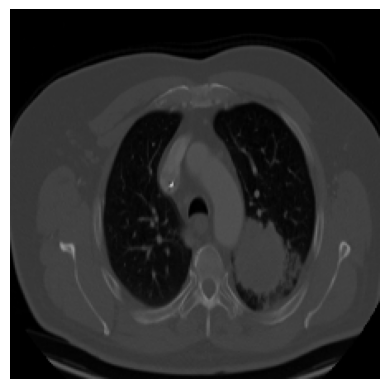

(224, 224, 3)

In [15]:
plt.imshow(train_images[400])  # Show the first image, change the index for different images
plt.axis('off')  # Hide the axes
plt.show()
train_images[100].shape

# Model Architecture

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)  # Replace the final layer with a Dense layer having 2 output classes (for binary classification)

model = Model(inputs=base_model.input, outputs=x)

In [19]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

epochs = 2

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Grad-CAM Impementation

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_gradcam(img_arrays, heatmap,image_id, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    heatmap = jet(heatmap)

    heatmap = image.array_to_img(heatmap)
    heatmap = heatmap.resize((img_arrays[image_id].shape[1], img_arrays[image_id].shape[0]))
    heatmap = image.img_to_array(heatmap)

    superimposed_img = heatmap[..., :3] * alpha + img_arrays[image_id]
    superimposed_img = image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plt.suptitle("Cancerous Detection")


    # Plot the original CT scan image in the second subplot
    axes[0].imshow(img_arrays[image_id])
    axes[0].set_title('Original CT Scan')
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    plt.tight_layout()

    plt.axis('off')
    plt.show()

# Replace 'conv5_block3_out' with your desired layer name
last_conv_layer_name = 'conv5_block3_out'

# Generate the heatmap
img_for_heatmap = np.expand_dims(train_images[307], axis=0)  # Add batch dimension
heatmap = make_gradcam_heatmap(img_for_heatmap, model, last_conv_layer_name)


plot_gradcam(train_images,heatmap,307)


In [ ]:
image_id =1

# Generating Adveresrial Pattern


In [24]:
loss_object = tensorflow.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    input_image = tensorflow.convert_to_tensor(input_image, dtype=tensorflow.float32)
    input_label = tensorflow.convert_to_tensor(input_label, dtype=tensorflow.float32)

    with tensorflow.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tensorflow.sign(gradient)

    # Extract the first channel of the signed gradient
    single_channel_signed_grad = signed_grad[..., 0]  # Assuming the channel dimension is the last one

    return single_channel_signed_grad

# Adverserial Attack

In [28]:
def sgdf_attack(image,adv_image):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))


  input_data_reshaped = np.expand_dims(image, axis=0)  # Add a batch dimension
  prediction_scores = model.predict(input_data_reshaped)
  non_cancerous_prediction_score = prediction_scores[0][0]
  non_cancerous_prediction_score_percentage = non_cancerous_prediction_score * 100

  axes[0].imshow(image)
  axes[0].set_title(f'Non-Cancerous Prediction Score of Original CT Scan: {round(non_cancerous_prediction_score_percentage,4)}')
  axes[0].axis('off')


  input_data_reshaped = np.expand_dims(adv_image, axis=0)
  prediction_scores = model.predict(input_data_reshaped)
  non_cancerous_prediction_score = prediction_scores[0][0]
  non_cancerous_prediction_score_percentage_adverserial = non_cancerous_prediction_score * 100

  axes[1].imshow(adv_image)
  axes[1].set_title(f'Non-Canserous Prediction Score of Adverserial CT Scan: {round(non_cancerous_prediction_score_percentage_adverserial,4)}')
  axes[1].axis('off')

  plt.tight_layout()
  plt.axis('off')
  plt.show()

# Generating Adverserial Traning Dataset


In [35]:
def generating_adverserial_dataset(images,images_labels):
  adverserial_dataset=[]
  epsilons = [20,35]

  for i in range(len(images)):

    test_img = np.expand_dims(images[i], axis=0)
    label = np.expand_dims(images_labels[i], axis=0)  # Adjust label shape if needed
    print(i)

    single_channel_signed_grad = create_adversarial_pattern(test_img, label)
    single_channel_signed_grad = tensorflow.expand_dims(single_channel_signed_grad, axis=-1)

    # Repeat the single channel across three channels
    rgb_signed_grad = tensorflow.tile(single_channel_signed_grad, [1, 1, 1, 3])  # Assuming channel dimension is the last one

    # Ensure the data type is float32
    rgb_signed_grad = tensorflow.cast(rgb_signed_grad, tensorflow.float32)


    rgb_signed_grad_numpy = rgb_signed_grad.numpy()  # Convert TensorFlow tensor to NumPy array

    # Ensure the shape is (224, 224, 3) (remove the batch dimension if it's causing the issue)
    rgb_signed_grad_numpy = rgb_signed_grad_numpy[0]  # If the first dimension is for batch (1 in your case)

    # Scale the values from [-1, 1] to [0, 1] for visualization
    rgb_signed_grad_numpy = (rgb_signed_grad_numpy * 0.5) + 0.5

    # # Display the image
    # plt.imshow(rgb_signed_grad_numpy* 0.5 + 0.5)
    # plt.show()

    if train_labels[i][0] == 1:
      print("here")
      adverserial_dataset.append(tensorflow.cast(images[i] +epsilons[0]* rgb_signed_grad_numpy* 0.5 + 1.6,tensorflow.uint8))
    else:
      print("there")
      adverserial_dataset.append(tensorflow.cast(images[i] +epsilons[1]* rgb_signed_grad_numpy* 0.5 + 1.6,tensorflow.uint8))
  return adverserial_dataset


# Saving Advesarial Datasets


In [27]:
import os
import cv2

def save_adversarial_images(images_labels,adversarial_dataset):
    # Directory names based on class labels
    class_names = {0: 'cancerous', 1: 'non_cancerous'}

    # Create directories for each class
    class_directories = {}
    for label in class_names.values():
        directory_path = f'/valid1/{label}_images/'
        class_directories[label] = directory_path
        os.makedirs(directory_path, exist_ok=True)

    for i, img in enumerate(adversarial_dataset):
        class_label = images_labels[i][0]
        label_name = class_names[class_label]
        # Save images in respective class directories
        save_path = os.path.join(class_directories[label_name], f'{label_name}_{i}.png')
        # img = np.uint8(img)
        cv2.imwrite(save_path, img)

    return class_directories

In [ ]:
import shutil

# Provide the path to the directory containing the images
base_directory = '/valid1/'

# Directory names to zip
cancerous_directory = 'cancerous_images'
non_cancerous_directory = 'non_cancerous_images'

# Zip the directories individually
shutil.make_archive(f'/valid1/cancerous_images', 'zip', base_directory, cancerous_directory)
shutil.make_archive(f'/valid1/non_cancerous_images', 'zip', base_directory, non_cancerous_directory)


'/valid1/non_cancerous_images.zip'

# Attack

In [ ]:
adverserial_dataset = generating_adverserial_dataset(train_images,train_labels)

1/1 [==============================] - 0s 132ms/step


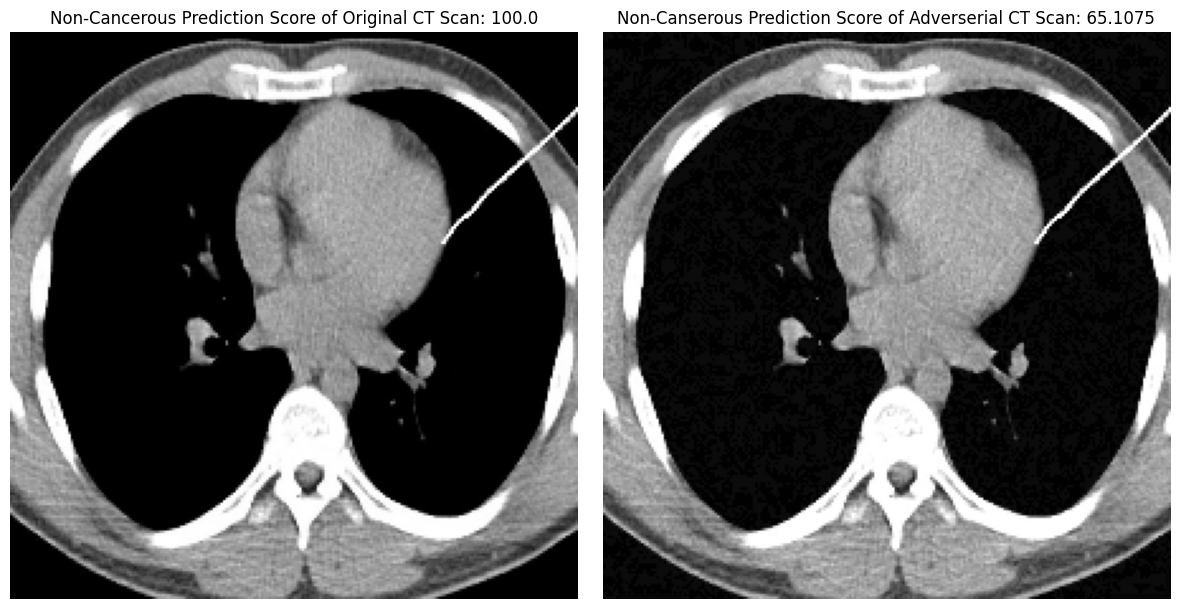

[1 0]


In [69]:
sgdf_attack(train_images[20],adverserial_dataset[20])
print(train_labels[20])

# Adversarial Traininig

In [70]:

# Assuming adverserial_dataset and train_images are NumPy arrays of images
# and adverserial_labels and train_labels are their respective labels
# Combine the datasets and labels
combined_data = np.concatenate((adverserial_dataset, train_images), axis=0)
combined_labels = np.concatenate((train_labels, train_labels), axis=0)

# Create an array of indices and shuffle them
num_samples = len(combined_data)
indices = np.random.permutation(num_samples)

# Shuffle the combined data and labels using the shuffled indices
shuffled_data = combined_data[indices]
shuffled_labels = combined_labels[indices]

# Assuming your model is called 'model' and you want to train it
# Train the model with the shuffled data and labels


In [71]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [72]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)  # Replace the final layer with a Dense layer having 2 output classes (for binary classification)

model = Model(inputs=base_model.input, outputs=x)

In [73]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

epochs = 2

history = model.fit(
    shuffled_data, shuffled_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

1/1 [==============================] - 0s 127ms/step


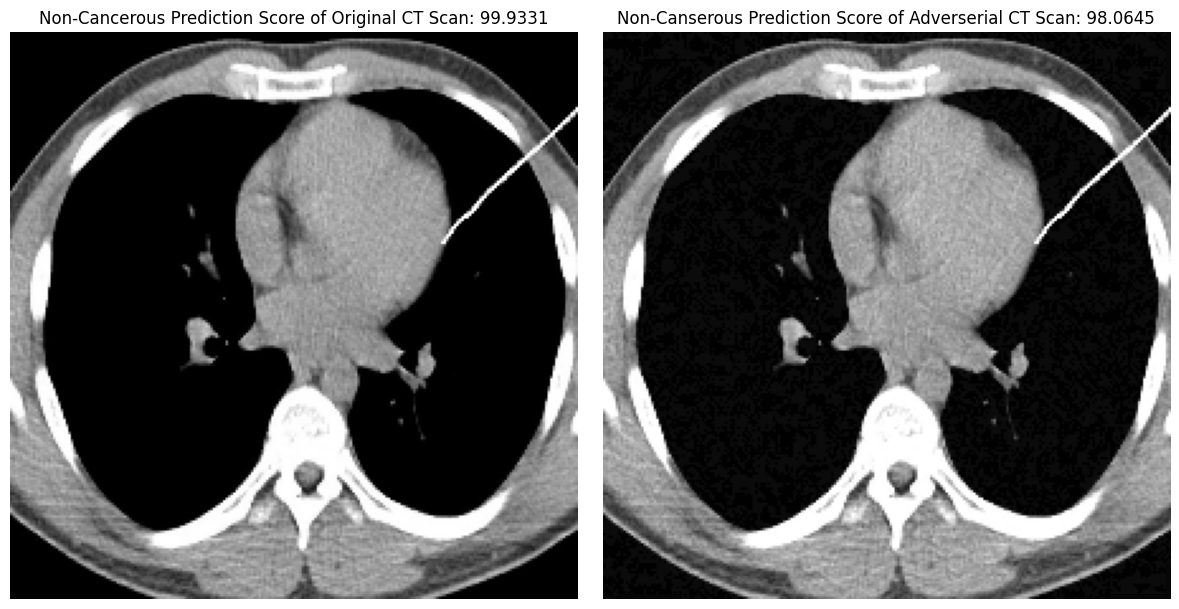

In [76]:
sgdf_attack(train_images[20],adverserial_dataset[20])